In [1]:
# import packages
import glob
from pathlib import Path
import scipy.stats
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pathos.threading import ThreadPool as Pool
from scipy.stats import gaussian_kde
import xarray as xr
from matplotlib import cm
import matplotlib
from collections import Counter
import shutil

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from f_sr_calculation import *

In [4]:
# work_dir=Path("/scratch/fransjevanoors/global_sr")
work_dir=Path("/mnt/u/LSM root zone/global_sr")

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# 2. optimize beta

In [6]:
df = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia.csv',index_col=0) 

In [7]:
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/se/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-10] # remove .year extension
    el_id_list.append(f)
print(len(el_id_list))

# get fiwu values for catchments with ia>0, se only written for ia>0, sd for all catchments
f = 'iwu2'
fm = []
for catch_id in el_id_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/se/{catch_id}_f{f}.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/se/{catch_id}_f{f}.csv',index_col=0)
        fmean = d['f'][:-1].mean()
        fm.append(fmean)
print(len(fm))

5331
5331


In [8]:
d=pd.DataFrame(index=el_id_list, columns=['fiwu'])
d['fiwu']=fm
d['ia'] = df['hi']
d['fopt'] = d['fiwu']/d['ia']
d.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f_optimization3.csv')

In [9]:
d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f_optimization3.csv',index_col=0)
d

,fiwu,ia,fopt
ITEMI002,0.047638,0.025706,1.853214
at_0000002,0.000000,0.000283,0.000000
at_0000008,0.000000,0.000526,0.000000
at_0000012,0.000000,0.000650,0.000000
at_0000039,0.000002,0.000003,0.621673
...,...,...,...
us_0002246,0.000000,0.005454,0.000000
us_0002094,0.000447,0.005952,0.075119
us_0002286,0.006387,0.006165,1.035949
us_0004301,0.000323,0.002728,0.118503


In [10]:
# MINIMIZE ABSOLUTE ERROR
f_min=0
f_max=4
nmax=10000
# A=np.zeros((int(nmax),8))
b = np.linspace(0,2.5,1000)
A=np.zeros((len(b),8))

# for n in range(1,int(nmax+1)): 
#     Rnum=np.random.rand(1)
#     f = f_min+(f_max-f_min)*Rnum

for n in range(1,len(b)+1):
    f = b[n-1]
    o = f*d['ia']
    er = o-d['fiwu']
    er_m = er.mean()
    er_mse = np.mean(er**2)
    er_mae = np.mean(np.abs(er))
    er_std =er.std()
    er_med = er.median()
    er_iqr =er.quantile(0.75) - er.quantile(0.25)
    er_rmse = np.sqrt(np.mean((o-d['fiwu'])**2))
    
    A[n-1,:] = [f,er_m,er_mse,er_mae,er_std,er_med,er_iqr,er_rmse]

ind=find_nearest(A[:,1],0)
fopt_mean=np.round(A[ind,0],3)
    
ind=np.argmin(A[:,2],0)
fopt_mse=np.round(A[ind,0],3)

ind=np.argmin(A[:,3],0)
fopt_mae=np.round(A[ind,0],3)

ind=np.argmin(A[:,4])
fopt_std=np.round(A[ind,0],3)

ind=find_nearest(A[:,5],0)
fopt_median=np.round(A[ind,0],3)

ind=np.argmin(A[:,6])
fopt_iqr=np.round(A[ind,0],3)

ind=np.argmin(A[:,7])
fopt_rmse=np.round(A[ind,0],3)

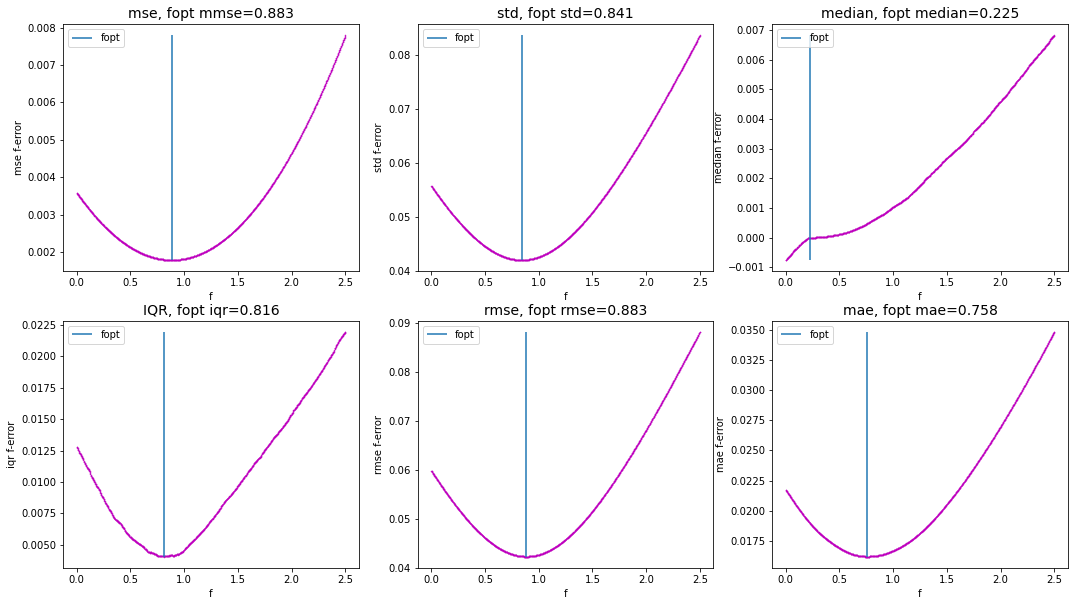

In [11]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(231)
ax.plot(A[:,0], A[:,2],'mo',markersize=0.5)
ax.vlines(fopt_mse,A[:,2].min(),A[:,2].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('mse f-error')
ax.set_title(f'mse, fopt mmse={fopt_mse}',size=14)
ax.legend()

ax = fig.add_subplot(232)
ax.plot(A[:,0], A[:,4],'mo',markersize=0.5)
ax.vlines(fopt_std,A[:,4].min(),A[:,4].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('std f-error')
ax.set_title(f'std, fopt std={fopt_std}',size=14)
ax.legend()

ax = fig.add_subplot(233)
ax.plot(A[:,0], A[:,5],'mo',markersize=0.5)
ax.vlines(fopt_median,A[:,5].min(),A[:,5].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('median f-error')
ax.set_title(f'median, fopt median={fopt_median}',size=14)
ax.legend()

ax = fig.add_subplot(234)
ax.plot(A[:,0], A[:,6],'mo',markersize=0.5)
ax.vlines(fopt_iqr,A[:,6].min(),A[:,6].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('iqr f-error')
ax.set_title(f'IQR, fopt iqr={fopt_iqr}',size=14)
ax.legend()

ax = fig.add_subplot(235)
ax.plot(A[:,0], A[:,7],'mo',markersize=0.5)
ax.vlines(fopt_rmse,A[:,7].min(),A[:,7].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('rmse f-error')
ax.set_title(f'rmse, fopt rmse={fopt_rmse}',size=14)
ax.legend()

ax = fig.add_subplot(236)
ax.plot(A[:,0], A[:,3],'mo',markersize=0.5)
ax.vlines(fopt_mae,A[:,3].min(),A[:,3].max(), label='fopt')
ax.set_xlabel('f')
ax.set_ylabel('mae f-error')
ax.set_title(f'mae, fopt mae={fopt_mae}',size=14)
ax.legend()

# fig.savefig(f'{work_dir}/output/figures/irrigation/optimization/monte_carlo_absdiff.jpg',dpi=300,bbox_inches='tight')

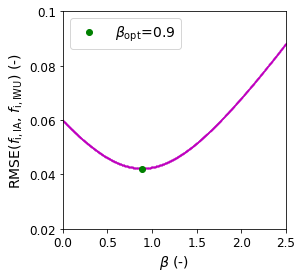

In [16]:
# RMSE figure optimization
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(A[:,0], A[:,7],'o',color='m',markersize=0.5)
ax.plot(1,1,'o',color='b',markersize=6)
ax.plot(fopt_rmse,0.042,'o',color='g',markersize=6,label=r'$\beta_{\mathrm{opt}}$='+str(np.round(fopt_rmse,1)))
ax.set_xlim(0,2.5)
ax.set_ylim(0.02,0.10)
ax.set_yticks([0.02,0.04,0.06,0.08,0.10])
ax.set_yticklabels([0.02,0.04,0.06,0.08,0.10],size=12)
ax.set_xticklabels([0.0,0.5,1.0,1.5,2.0,2.5],size=12)
ax.set_xlabel(r'$\beta$ (-)',fontsize=14)
ax.set_ylabel('RMSE($f_{\mathrm{i,IA}}$, $f_{\mathrm{i,IWU}}$) (-)',fontsize=14)
# ax.set_title('min(RMSE) for $f_{\mathrm{i,opt}}$='+str(fopt_rmse),size=14)
ax.legend(fontsize=14,loc='upper left')

,median,mean,std,iqr,rmse,mae
"fi,opt*IA - fi,iwu",0.001,-0.004,0.042,0.004,0.042,0.017


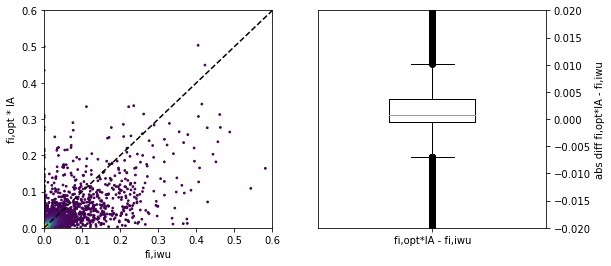

In [15]:
d['fi,opt'] = 0.9*d['ia']
d['dif'] = d['fi,opt']-d['fiwu']
d['reldif'] = (d['fi,opt']-d['fiwu'])/d['fiwu'] * 100

d = d.dropna()
x = d['fiwu']
y = d['fi,opt']

# calculate point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
# ax.plot(d['fiwu'],d['f1.85ia'],'mo',markersize=1)
ax.scatter(x,y,c=z,s=3)
ax.plot([0,12],[0,12],'k--')
ax.set_xlabel('fi,iwu')
ax.set_ylabel('fi,opt * IA')
ax.set_xlim(0,0.6)
ax.set_ylim(0,0.6)

ax = fig.add_subplot(122)
d = d.dropna()
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.boxplot(d['dif'])
ax.set_xticklabels(['fi,opt*IA - fi,iwu'])
ax.set_ylabel('abs diff fi,opt*IA - fi,iwu')
ax.set_ylim(-0.02,0.02)
ax.set_xlim(0.8,1.2)

de = d['dif']

e = pd.DataFrame(index=['fi,opt*IA - fi,iwu'])
e['median']=np.round(de.median(),3)
e['mean']=np.round(de.mean(),3)
e['std']=np.round(de.std(),3)
e['iqr'] = np.round((de.quantile(0.75) - de.quantile(0.25)),3)
e['rmse'] = np.round(np.sqrt(np.mean((de**2))),3)
e['mae'] = np.round(np.mean(np.abs(de)),3)
e

## SD CALCULATION

Run Sd calculation for three cases:
- NI
- IWU
- IAF

In [16]:
data_sources = 'gswp-p_gleam-ep_gswp-t'
ir_case = 'iwu' # or 'ni' or 'iwu' or 'iaf'
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
snow_ids = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')
snow_dir = f'{work_dir}/output/snow/timeseries_gswp'

# catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:]
# itlist = np.genfromtxt(f'{work_dir}/data/po_basin/organized_data/it_selected_catchments.txt',dtype='str')
uslist = np.genfromtxt(f'{work_dir}/output/catchment_characteristics/us_selected_catchments_{data_sources}.txt',dtype='str')
catch_list = uslist

# check which catchments are missing
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sd/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-10] # remove .year extension
    el_id_list.append(f)
dif = list(set(catch_list) - set(el_id_list))
print(len(dif))
catch_list = dif

# check which catchments are missing
# el_id_list=[]
# for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sd/*.csv'):
#     f = os.path.split(filepath)[1] # remove full path
#     f = f[:-4] # remove .year extension
#     el_id_list.append(f)
# dif = list(set(catch_list) - set(el_id_list))
# print(len(dif))
# catch_list = dif

catch_id_list = catch_list[0:20]
pep_dir_list = [pep_dir] * len(catch_id_list)
q_dir_list = [q_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list)
snow_id_list = [snow_ids] * len(catch_id_list)
snow_dir_list = [snow_dir] * len(catch_id_list)
work_dir_list = [work_dir] * len(catch_id_list)
ir_case_list = [ir_case] * len(catch_id_list)

run_sd_calculation_parallel(catch_id_list,pep_dir_list,q_dir_list,out_dir_list,snow_id_list,snow_dir_list,work_dir_list,ir_case_list)

27


In [20]:
# copy iaf results here
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments_gswp-p_gleam-ep_gswp-t/sd/us*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] 
    a = pd.read_csv(filepath,index_col=0)
    a.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sd/{f}_f0.9ia.csv')

## SR CALCULATION

In [34]:
sd_list1=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_rzyear/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-14] 
    sd_list1.append(f)
len(sd_list1)

4861

In [38]:
sd_list2=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_rzyear/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-21] 
    sd_list2.append(f)
len(sd_list2)

4858

In [36]:
sd_list3=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_rzyear/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-20] 
    sd_list3.append(f)
len(sd_list3)

4860

In [39]:
ir_case = 'iaf' #'ni' or iwu or iaf
catch_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel_area_wb.txt',dtype='str')[:]
# itlist = np.genfromtxt(f'{work_dir}/data/po_basin/organized_data/it_selected_catchments.txt',dtype='str')

sd_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sd/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-11]
    # f = f[:-4] 
    sd_list.append(f)

dif = list(set(sd_list) - set(sd_list2))
print(len(dif))

# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'

# define return periods
rp_array = [1.5,2,3,5,10,20,30,40,50,60,70,80]
catch_id_list = dif[:]
sd_dir_list = [sd_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list) 
rp_array_list = [rp_array] * len(catch_id_list) 
ir_case_list = [ir_case] * len(catch_id_list)

run_sr_calculation_parallel(catch_id_list,rp_array_list,sd_dir_list,out_dir_list,ir_case_list)

1522


Combine calculated Sr values in one dataframe for each irrigation case:

In [8]:
# combine Sr output in dataframe - f no irri
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_rzyear/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-14] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['1.5','2.0','3.0','5.0','10.0','20.0','30.0','40.0','50.0','60.0','70.0','80.0'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
# sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit_rzyear.csv')
# sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points_rzyear.csv')

# sr_df_gf = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit_rzyear.csv',index_col=0)
# sr_df_p = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points_rzyear.csv',index_col=0)
# sr_n = sr_df_p.dropna()

p = []
# p = sr_n.index
di = list(set(c_list) - set(p)) #missing catchments in dataframe
print(len(di))

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_rzyear/{catch_id}_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_rzyear/{catch_id}_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_rzyear/{catch_id}_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit_rzyear.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points_rzyear.csv')

4861
4861


In [9]:
sr_df_gf

,1.5,2.0,3.0,5.0,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0
105102A,332.631821,352.883671,376.461873,402.722904,435.720812,467.373199,485.582036,498.419829,508.343966,516.435464,523.266834,529.178202
ch_0000091,3.323512,3.945646,4.669965,5.476701,6.490393,7.46275,8.022123,8.416499,8.721367,8.969937,9.179796,9.361392
221207,21.281267,26.861838,33.359014,40.595467,49.688324,58.410411,63.428012,66.965576,69.700257,71.929939,73.812382,75.44131
221210,79.030826,98.886411,122.003263,147.750449,180.102693,211.135743,228.988291,241.574889,251.304843,259.238016,265.935718,271.731419
226220,102.061309,119.662571,140.154829,162.978784,191.657886,219.167569,234.993211,246.150778,254.776032,261.808504,267.745776,272.883457
...,...,...,...,...,...,...,...,...,...,...,...,...
us_0001974,84.048185,109.326072,138.755834,171.534242,212.721463,252.229235,274.957081,290.980915,303.367993,313.467611,321.994369,329.3728
us_0006369,108.325011,132.39605,160.420741,191.634202,230.855012,268.476556,290.119302,305.378106,317.173785,326.791215,334.910878,341.937039
us_0002163,62.026083,84.995847,111.73838,141.523792,178.95021,214.850529,235.503097,250.063795,261.319809,270.497232,278.245412,284.950119
us_0003410,58.722116,72.920413,89.450771,107.862023,130.99641,153.187469,165.953438,174.95384,181.911518,187.584358,192.373739,196.518119


In [40]:
# combine Sr output in dataframe - f0.9ia
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_rzyear/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-21] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['1.5','2.0','3.0','5.0','10.0','20.0','30.0','40.0','50.0','60.0','70.0','80.0'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
# sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_gumbelfit2_rzyear.csv')
# sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_points2_rzyear.csv')

# sr_df_gf = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_gumbelfit_rzyear.csv',index_col=0)
# sr_df_p = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_points_rzyear.csv',index_col=0)
# sr_n = sr_df_p.dropna()

p=[]
# p = sr_n.index
di = list(set(c_list) - set(p)) #missing catchments in dataframe

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_rzyear/{catch_id}_f0.9ia_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_rzyear/{catch_id}_f0.9ia_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_rzyear/{catch_id}_f0.9ia_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_gumbelfit2_rzyear_v2.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_points2_rzyear_v2.csv')

4859


In [33]:
# combine Sr output in dataframe - fiwu2
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_rzyear/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-20] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['1.5','2.0','3.0','5.0','10.0','20.0','30.0','40.0','50.0','60.0','70.0','80.0'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
# sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_gumbelfit2_rzyear.csv')
# sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_points2_rzyear.csv')

# sr_df_gf = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_gumbelfit2_rzyear.csv',index_col=0)
# sr_df_p = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_points2_rzyear.csv',index_col=0)
# sr_n = sr_df_gf.dropna()
p=[]
# p = sr_n.index
di = list(set(c_list) - set(p)) #missing catchments in dataframe

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_rzyear/{catch_id}_fiwu2_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_rzyear/{catch_id}_fiwu2_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_rzyear/{catch_id}_fiwu2_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_gumbelfit2_rzyear_v2.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_points2_rzyear_v2.csv')

4860


In [25]:
# NON ROOT ZONE YEARS

In [22]:
# combine Sr output in dataframe - f no irri
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-14] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['1.5','2.0','3.0','5.0','10.0','20.0','30.0','40.0','50.0','60.0','70.0','80.0'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
# sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit_rzyear.csv')
# sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points_rzyear.csv')

# sr_df_gf = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit_rzyear.csv',index_col=0)
# sr_df_p = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points_rzyear.csv',index_col=0)
# sr_n = sr_df_p.dropna()

p = []
# p = sr_n.index
di = list(set(c_list) - set(p)) #missing catchments in dataframe
print(len(di))

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/{catch_id}_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/{catch_id}_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr/{catch_id}_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_gumbelfit.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points.csv')

4516
4516


In [24]:
# combine Sr output in dataframe - f0.9ia
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-21] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['1.5','2.0','3.0','5.0','10.0','20.0','30.0','40.0','50.0','60.0','70.0','80.0'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
# sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_gumbelfit2_rzyear.csv')
# sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_points2_rzyear.csv')

# sr_df_gf = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_gumbelfit_rzyear.csv',index_col=0)
# sr_df_p = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_points_rzyear.csv',index_col=0)
# sr_n = sr_df_p.dropna()

p=[]
# p = sr_n.index
di = list(set(c_list) - set(p)) #missing catchments in dataframe

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/{catch_id}_f0.9ia_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/{catch_id}_f0.9ia_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr/{catch_id}_f0.9ia_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_gumbelfit2.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_points2.csv')

4514


In [25]:
# combine Sr output in dataframe - fiwu2
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-20] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['1.5','2.0','3.0','5.0','10.0','20.0','30.0','40.0','50.0','60.0','70.0','80.0'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
# sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_gumbelfit2_rzyear.csv')
# sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_points2_rzyear.csv')

# sr_df_gf = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_gumbelfit2_rzyear.csv',index_col=0)
# sr_df_p = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_points2_rzyear.csv',index_col=0)
sr_n = sr_df_gf.dropna()
# p=[]
p = sr_n.index
di = list(set(c_list) - set(p)) #missing catchments in dataframe

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr/{catch_id}_fiwu2_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr/{catch_id}_fiwu2_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr/{catch_id}_fiwu2_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_gumbelfit2.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_points2.csv')

4515


## check for irrigation and snow catchments

In [6]:
sr_df_ni = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points_rzyear.csv', index_col=0)
df = pd.read_csv(f'{work_dir}/data/irrigated_area/output/combined_ia.csv',index_col=0)
snow_ids = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')
df = df.loc[sr_df_ni.index]

a=[]
for c in snow_ids:
    if (c in df.index):
        a.append(df.loc[c])
dfs = pd.DataFrame(a)
dfs

,ei,ec,hi,hc
ITLOM137,NaN,NaN,0.103610,NaN
ITLOM124,NaN,NaN,0.006207,NaN
ITLOM122,NaN,NaN,0.008220,NaN
ITTRE243,NaN,NaN,0.000697,NaN
ITTRE248,NaN,NaN,0.003045,NaN
...,...,...,...,...
us_0006518,0.012488,0.012787,0.012488,0.012580
us_0006534,0.000551,0.000664,0.000551,0.000681
us_0006936,0.017495,0.016324,0.017495,0.018488
us_0008655,0.072351,0.072808,0.072351,0.071971


In [7]:
len(dfs[dfs.hi>0.05])

27

In [8]:
d = dfs[dfs.hi>0.05]
catch_id_list = d.index
catch_id_list

Index(['ITLOM137', 'ITTRE262', 'ITVAL288', 'ca_0000165', 'ca_0000526',
       'ca_0000542', 'ca_0000567', 'ca_0000683', 'ca_0000686', 'ca_0000696',
       'ca_0000703', 'ca_0000710', 'ca_0000711', 'ca_0000728', 'ca_0002153',
       'ca_0002248', 'ca_0002395', 'ca_0003004', 'ca_0004609', 'ca_0004712',
       'ca_0005666', 'ca_0005743', 'ca_0005776', 'it_0000207', 'us_0004867',
       'us_0008655', 'us_0008656'],
      dtype='object')

In [9]:
# run sd and s calculation for 27 catchments without snow to see effect of snow (for NI, IWU and IAF)

In [12]:
# sd calculation
ir_case = 'iwu' # or 'ni' or 'iwu' or 'iaf'
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/snow_irri_effects'
snow_ids = []
snow_dir = f'{work_dir}/output/snow/timeseries_gswp'

catch_list = catch_id_list

catch_id_list = catch_list[:]
pep_dir_list = [pep_dir] * len(catch_id_list)
q_dir_list = [q_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list)
snow_id_list = [snow_ids] * len(catch_id_list)
snow_dir_list = [snow_dir] * len(catch_id_list)
work_dir_list = [work_dir] * len(catch_id_list)
ir_case_list = [ir_case] * len(catch_id_list)

run_sd_calculation_parallel(catch_id_list,pep_dir_list,q_dir_list,out_dir_list,snow_id_list,snow_dir_list,work_dir_list,ir_case_list)

In [16]:
# sr calculation
ir_case = 'iwu' #'ni' or iwu or iaf
catch_list = catch_id_list

sd_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/f0.9ia/sd/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-11] 
    sd_list.append(f)

# define directories
sd_dir = f'{work_dir}/output/sr_calculation/snow_irri_effects'
out_dir = f'{work_dir}/output/sr_calculation/snow_irri_effects'

# define return periods
rp_array = [1.5,2,3,5,10,20,30,40,50,60,70,80]
catch_id_list = catch_list
sd_dir_list = [sd_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list) 
rp_array_list = [rp_array] * len(catch_id_list) 
ir_case_list = [ir_case] * len(catch_id_list)

run_sr_calculation_parallel(catch_id_list,rp_array_list,sd_dir_list,out_dir_list,ir_case_list)

In [19]:
# combine Sr output in dataframe - f0.9ia
c_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/f0.9ia/sr/*gumbelfit.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-21] # remove .year extension
    c_list.append(f)
print(len(c_list))

sr_df_gf = pd.DataFrame(index=c_list, columns=['1.5','2.0','3.0','5.0','10.0','20.0','30.0','40.0','50.0','60.0','70.0','80.0'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
p=[]
di = list(set(c_list) - set(p)) #missing catchments in dataframe

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/f0.9ia/sr/{catch_id}_f0.9ia_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/f0.9ia/sr/{catch_id}_f0.9ia_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/f0.9ia/sr/{catch_id}_f0.9ia_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/f0.9ia/sr_irri_f0.9ia_combined_gumbelfit2.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/f0.9ia/sr_irri_f0.9ia_combined_points2.csv')

27


In [20]:
# combine Sr output in dataframe - fiwu2
sr_df_gf = pd.DataFrame(index=c_list, columns=['1.5','2.0','3.0','5.0','10.0','20.0','30.0','40.0','50.0','60.0','70.0','80.0'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
sr_n = sr_df_gf.dropna()
p = sr_n.index
di = list(set(c_list) - set(p)) #missing catchments in dataframe

for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/fiwu2/sr/{catch_id}_fiwu2_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/fiwu2/sr/{catch_id}_fiwu2_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/fiwu2/sr/{catch_id}_fiwu2_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/fiwu2/sr_irri_fiwu2_combined_gumbelfit2.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/fiwu2/sr_irri_fiwu2_combined_points2.csv')

In [21]:
# combine Sr output in dataframe - f no irri
sr_df_gf = pd.DataFrame(index=c_list, columns=['1.5','2.0','3.0','5.0','10.0','20.0','30.0','40.0','50.0','60.0','70.0','80.0'])
sr_df_p = pd.DataFrame(index=c_list, columns=['k3','k5'])
p = []
di = list(set(c_list) - set(p)) #missing catchments in dataframe
for catch_id in di[:]:
    if os.path.exists(f'{work_dir}/output/sr_calculation/snow_irri_effects/no_irri/sr/{catch_id}_gumbelfit.csv'):
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/no_irri/sr/{catch_id}_gumbelfit.csv',index_col=0)
        sr_df_gf.loc[catch_id] = d.iloc[0]
        
        d = pd.read_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/no_irri/sr/{catch_id}_points.csv',index_col=0)
        l = [2]#,3,5,10,20,30,40,50,60,70,80]
        for i in range(len(l)):
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1]])
            sr_df_p.loc[catch_id]['k3'] = sr
            
            a = d['T_a'].values
            ix1 = find_nearest(a,l[i])
            sr = np.mean(d.sd.values[[ix1,ix1-1,ix1+1,ix1-2,ix1+2]])
            sr_df_p.loc[catch_id]['k5'] = sr

sr_df_gf.to_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/no_irri/sr_no_irri_combined_gumbelfit.csv')
sr_df_p.to_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/no_irri/sr_no_irri_combined_points.csv')

27


In [26]:
# combine all results snow and irri
ns_ni = pd.read_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/no_irri/sr_no_irri_combined_points.csv',index_col=0)
ns_iaf = pd.read_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/f0.9ia/sr_irri_f0.9ia_combined_points2.csv',index_col=0)
ns_iwu = pd.read_csv(f'{work_dir}/output/sr_calculation/snow_irri_effects/irri/fiwu2/sr_irri_fiwu2_combined_points2.csv',index_col=0)

s_ni = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/no_irri/sr_no_irri_combined_points_rzyear.csv',index_col=0)
s_iaf = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f0.9ia/sr_irri_f0.9ia_combined_points2_rzyear.csv',index_col=0)
s_iwu = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/sr_irri_fiwu2_combined_points2_rzyear.csv',index_col=0)

df = pd.DataFrame(index=nsi_ni.index, columns=['ns_ni','ns_iaf','ns_iwu','s_ni','s_iaf','s_iwu'])
df.ns_ni = ns_ni.k3
df.ns_iaf = ns_iaf.k3
df.ns_iwu = ns_iwu.k3
df.s_ni = s_ni.k3
df.s_iaf = s_iaf.k3
df.s_iwu = s_iwu.k3

In [27]:
df

,ns_ni,ns_iaf,ns_iwu,s_ni,s_iaf,s_iwu
ca_0000165,65.395720,41.297130,61.909168,75.360081,50.609819,70.122674
ca_0000526,138.800833,131.881815,132.092321,150.705724,144.570678,144.923724
ca_0000542,120.468739,110.623636,112.952996,124.433654,115.708735,117.207421
ca_0000567,127.559028,120.482718,117.163987,138.718698,132.467615,129.351880
ca_0000683,87.074331,76.283283,78.740221,95.134683,83.484946,86.696411
ca_0000686,67.384769,47.742962,53.174343,72.910651,53.240986,58.951059
ca_0000696,100.096746,80.068553,90.194125,102.583159,76.350052,88.630617
ca_0000703,91.523674,69.487331,83.898550,103.393290,74.557495,91.349104
ca_0000710,87.067986,59.748194,74.930834,88.815466,57.168598,73.480509
ca_0000711,131.115445,120.590430,127.020764,138.832424,129.776575,134.858557


In [30]:
df.median()

ns_ni     88.050378
ns_iaf    79.548661
ns_iwu    83.888929
s_ni      89.781400
s_iaf     76.350052
s_iwu     86.696411
dtype: float64

In [31]:
df.mean()

ns_ni     100.019971
ns_iaf     90.135215
ns_iwu     94.478334
s_ni       93.017540
s_iaf      82.461438
s_iwu      87.133050
dtype: float64

## process Ss

In [87]:
el_id_list=[]
for filepath in glob.iglob(f'{work_dir}/output/sr_calculation/sd_catchments/irri/fiwu2/se/*.csv'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-10] # remove .year extension
    el_id_list.append(f)
print(len(el_id_list))

4635


In [88]:
catch_list = el_id_list[:]

# get fiwu values for catchments with ia>0, se only written for ia>0, sd for all catchments
f = '0.9ia'
fm = []
fs = []
fmd = []
ufm = []
ufs = []
ufmd = []
c = []
for catch_id in catch_list:
    if os.path.exists(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f{f}/se/{catch_id}_f{f}.csv'):
        if ((os.stat(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f{f}/se/{catch_id}_f{f}.csv').st_size == 0)==False):
            d = pd.read_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f{f}/se/{catch_id}_f{f}.csv',index_col=0)
            semean = d['se'][:-1].mean()
            sestd = d['se'][:-1].std()
            semed = d['se'][:-1].median()
            usemean = d['se_used'][:-1].mean()
            usestd = d['se_used'][:-1].std()
            usemed = d['se_used'][:-1].median()
            fm.append(semean)
            fs.append(sestd)
            fmd.append(semed)
            ufm.append(usemean)
            ufs.append(usestd)
            ufmd.append(usemed)
            c.append(catch_id)
print(len(fm))

4617


In [89]:
df = pd.DataFrame(index=c, columns=['se_mean','se_med','se_std','se_u_mean','se_u_med','se_u_std'])
df['se_mean'] = fm
df['se_med'] = fmd
df['se_std'] = fs
df['se_u_mean'] = ufm
df['se_u_med'] = ufmd
df['se_u_std'] = ufs

In [90]:
df

,se_mean,se_med,se_std,se_u_mean,se_u_med,se_u_std
ITEMI002,41.712954,0.000000,82.807757,0.965027,0.000000,1.915754
at_0000002,269.894526,238.107419,151.437294,0.068769,0.060670,0.038586
at_0000008,429.602336,472.816511,164.004743,0.217547,0.239431,0.083051
at_0000012,1061.950651,1119.515191,274.121193,0.415793,0.438332,0.107329
at_0000039,959.123427,919.755027,276.938776,0.002597,0.002491,0.000750
...,...,...,...,...,...,...
ITTOS343,87.114219,0.000000,129.124234,1.038349,0.000000,1.539084
ITTOS361,39.334022,0.000000,67.432614,1.830386,0.000000,3.137937
ITTOS339,58.810490,0.000000,97.039589,1.364800,0.000000,2.251973
ITTOS372,37.938966,0.000000,78.934075,1.444440,0.000000,3.005236


In [91]:
df.to_csv(f'{work_dir}/output/sr_calculation/sd_catchments/irri/f{f}/se_combined.csv')